In [1]:
%load_ext blackcellmagic

In [3]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression, SGDClassifier


Petite analyse exploratoire des features tactiques (sur les tirs de 4 matchs)

On commence par désérialiser les données

In [4]:
with open("train_tactical_fitness.pkl", "rb") as file:
    shots = pickle.load(file)
shots.head()
shots.columns

Index(['shot_id', 'player', 'team', 'match', 'ht', 'minu', 'sec', 'time_sec',
       'x', 'y', 'dist_to_goal', 'angle_to_y', 'field_of_view', 'dist_to_gk',
       'closest_def', 'nb_def_in_cone', 'density', 'goal', 'acc_nb',
       'acc_time_med', 'acc_time_max', 'acc_dist_km', 'cour_nb',
       'cour_time_med', 'cour_time_max', 'cour_dist_km', 'dist_km',
       'time_played'],
      dtype='object')

On va plotter chaque feature selon la variable `goal` :

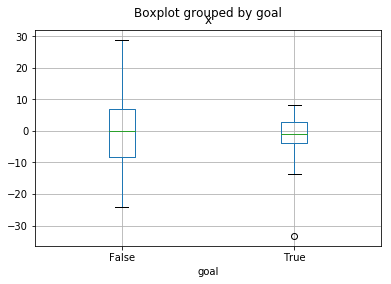

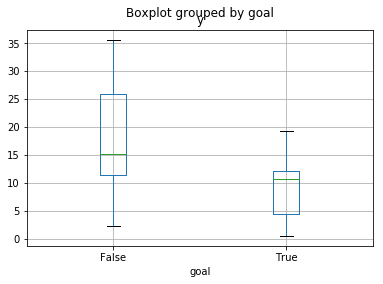

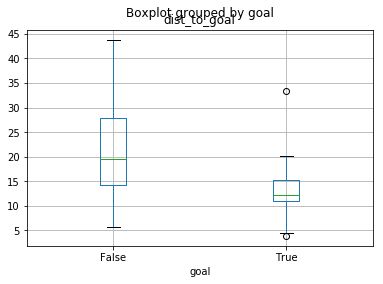

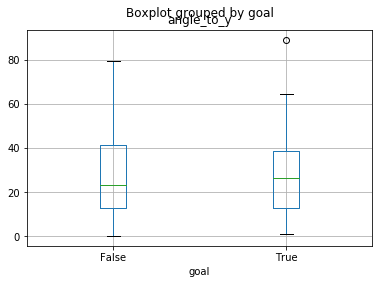

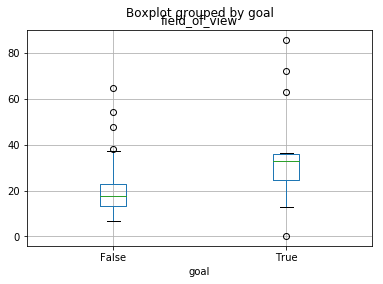

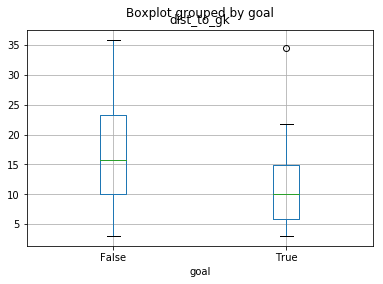

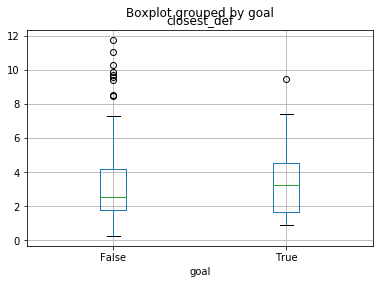

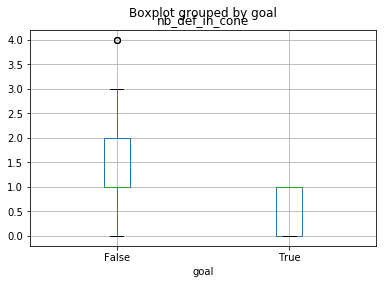

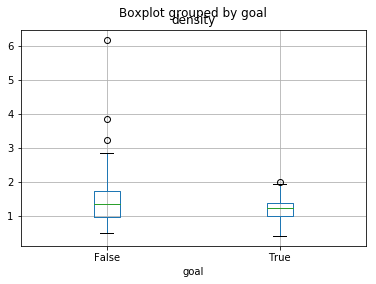

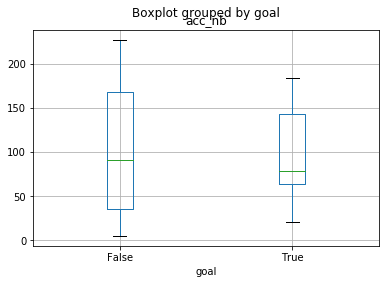

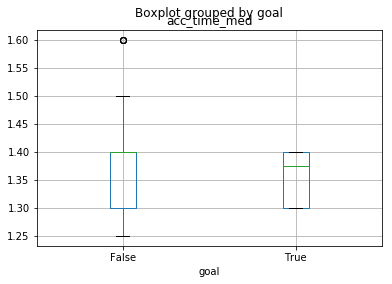

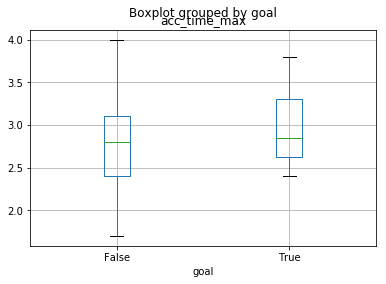

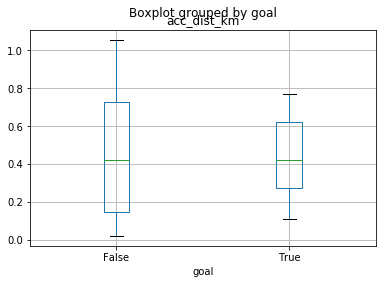

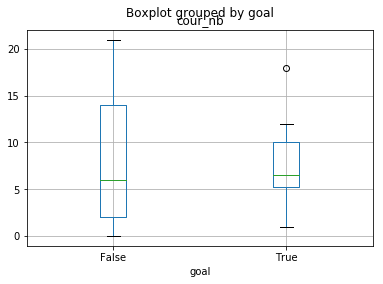

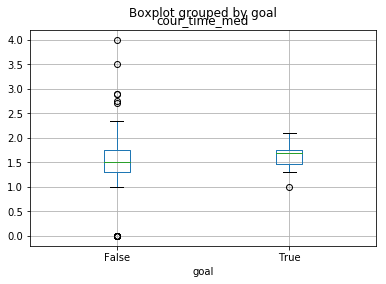

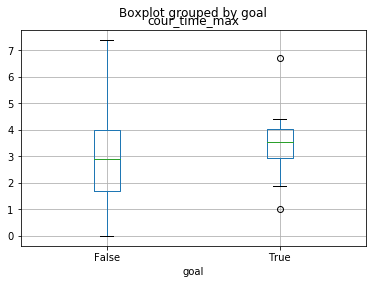

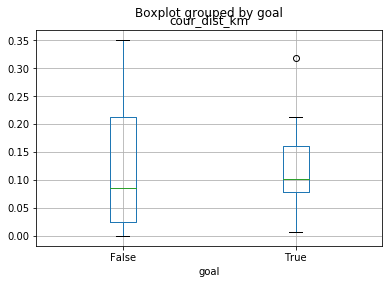

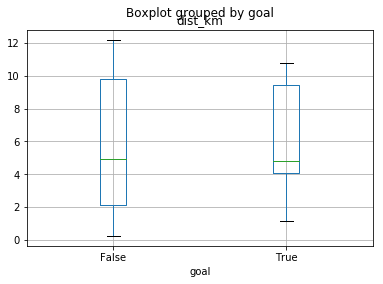

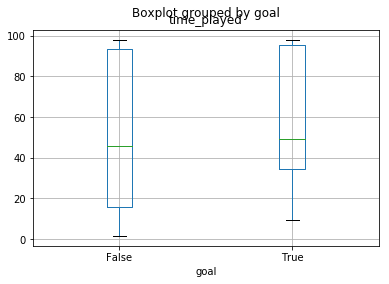

In [6]:
features = [
    "x",
    "y",
    "dist_to_goal",
    "angle_to_y",
    "field_of_view",
    "dist_to_gk",
    "closest_def",
    "nb_def_in_cone",
    "density",
    'acc_nb',
    'acc_time_med',
    'acc_time_max',
    'acc_dist_km',
    'cour_nb',
    'cour_time_med',
    'cour_time_max',
    'cour_dist_km',
    'dist_km',
    'time_played'
]

for feature in features:
    #boxplot = plt.boxplot(shots[feature], by="goal")
    boxplot = shots.boxplot(column= [feature], by="goal")


* Très peu de buts sont marqués quand $|x| > 10m$, il serait donc judicieux de prendre la valeur absolue de cette variable
* Majorité des tirs tentés : y entre 10 et 25m. majorités des buts : y entre 5 et 12m
* Même constant pour la distance au centre des cages : $[15, 30]$ vs $[10, 15]$
* l'angle par rapport à Y n'a pas (ou très peu) d'influence sur les chances de réussite d'un tir
* On augmente significativement ses chances de marquer avec un champ de vision $> 20°$
* La distance au goal a l'air d'être moins déterminante sur les chances de réussite d'un tir que la distance au centre des cages, mais elle reste quand même très importante
* la distance au défenseur le plus proche n'a pas l'air d'être très significative
* aucun but n'a été marqué alors qu'il avait plus d'un défenseur dans le cône de tir ! À voir avec + de données si on ne devrait pas discrétiser cette variable
* La densité a l'air de jouer un rôle : plus elle est grande, moins il est facile de marquer.

* À part la densité et le nombre de défenseurs dans le cône de tir, les variables sont du même ordre de grandeur. On aura donc pas à les normaliser (à part peut-être la densité), tant mieux car cela facilitera l'interprétation

Jetons un oeil au corrplot

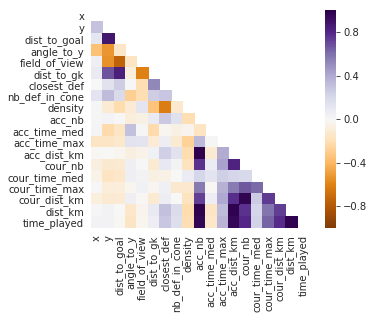

In [7]:
def corr_plot(df):
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, center=0, square=True, cmap="PuOr")
    return ax

shots.loc[:, features].pipe(corr_plot)


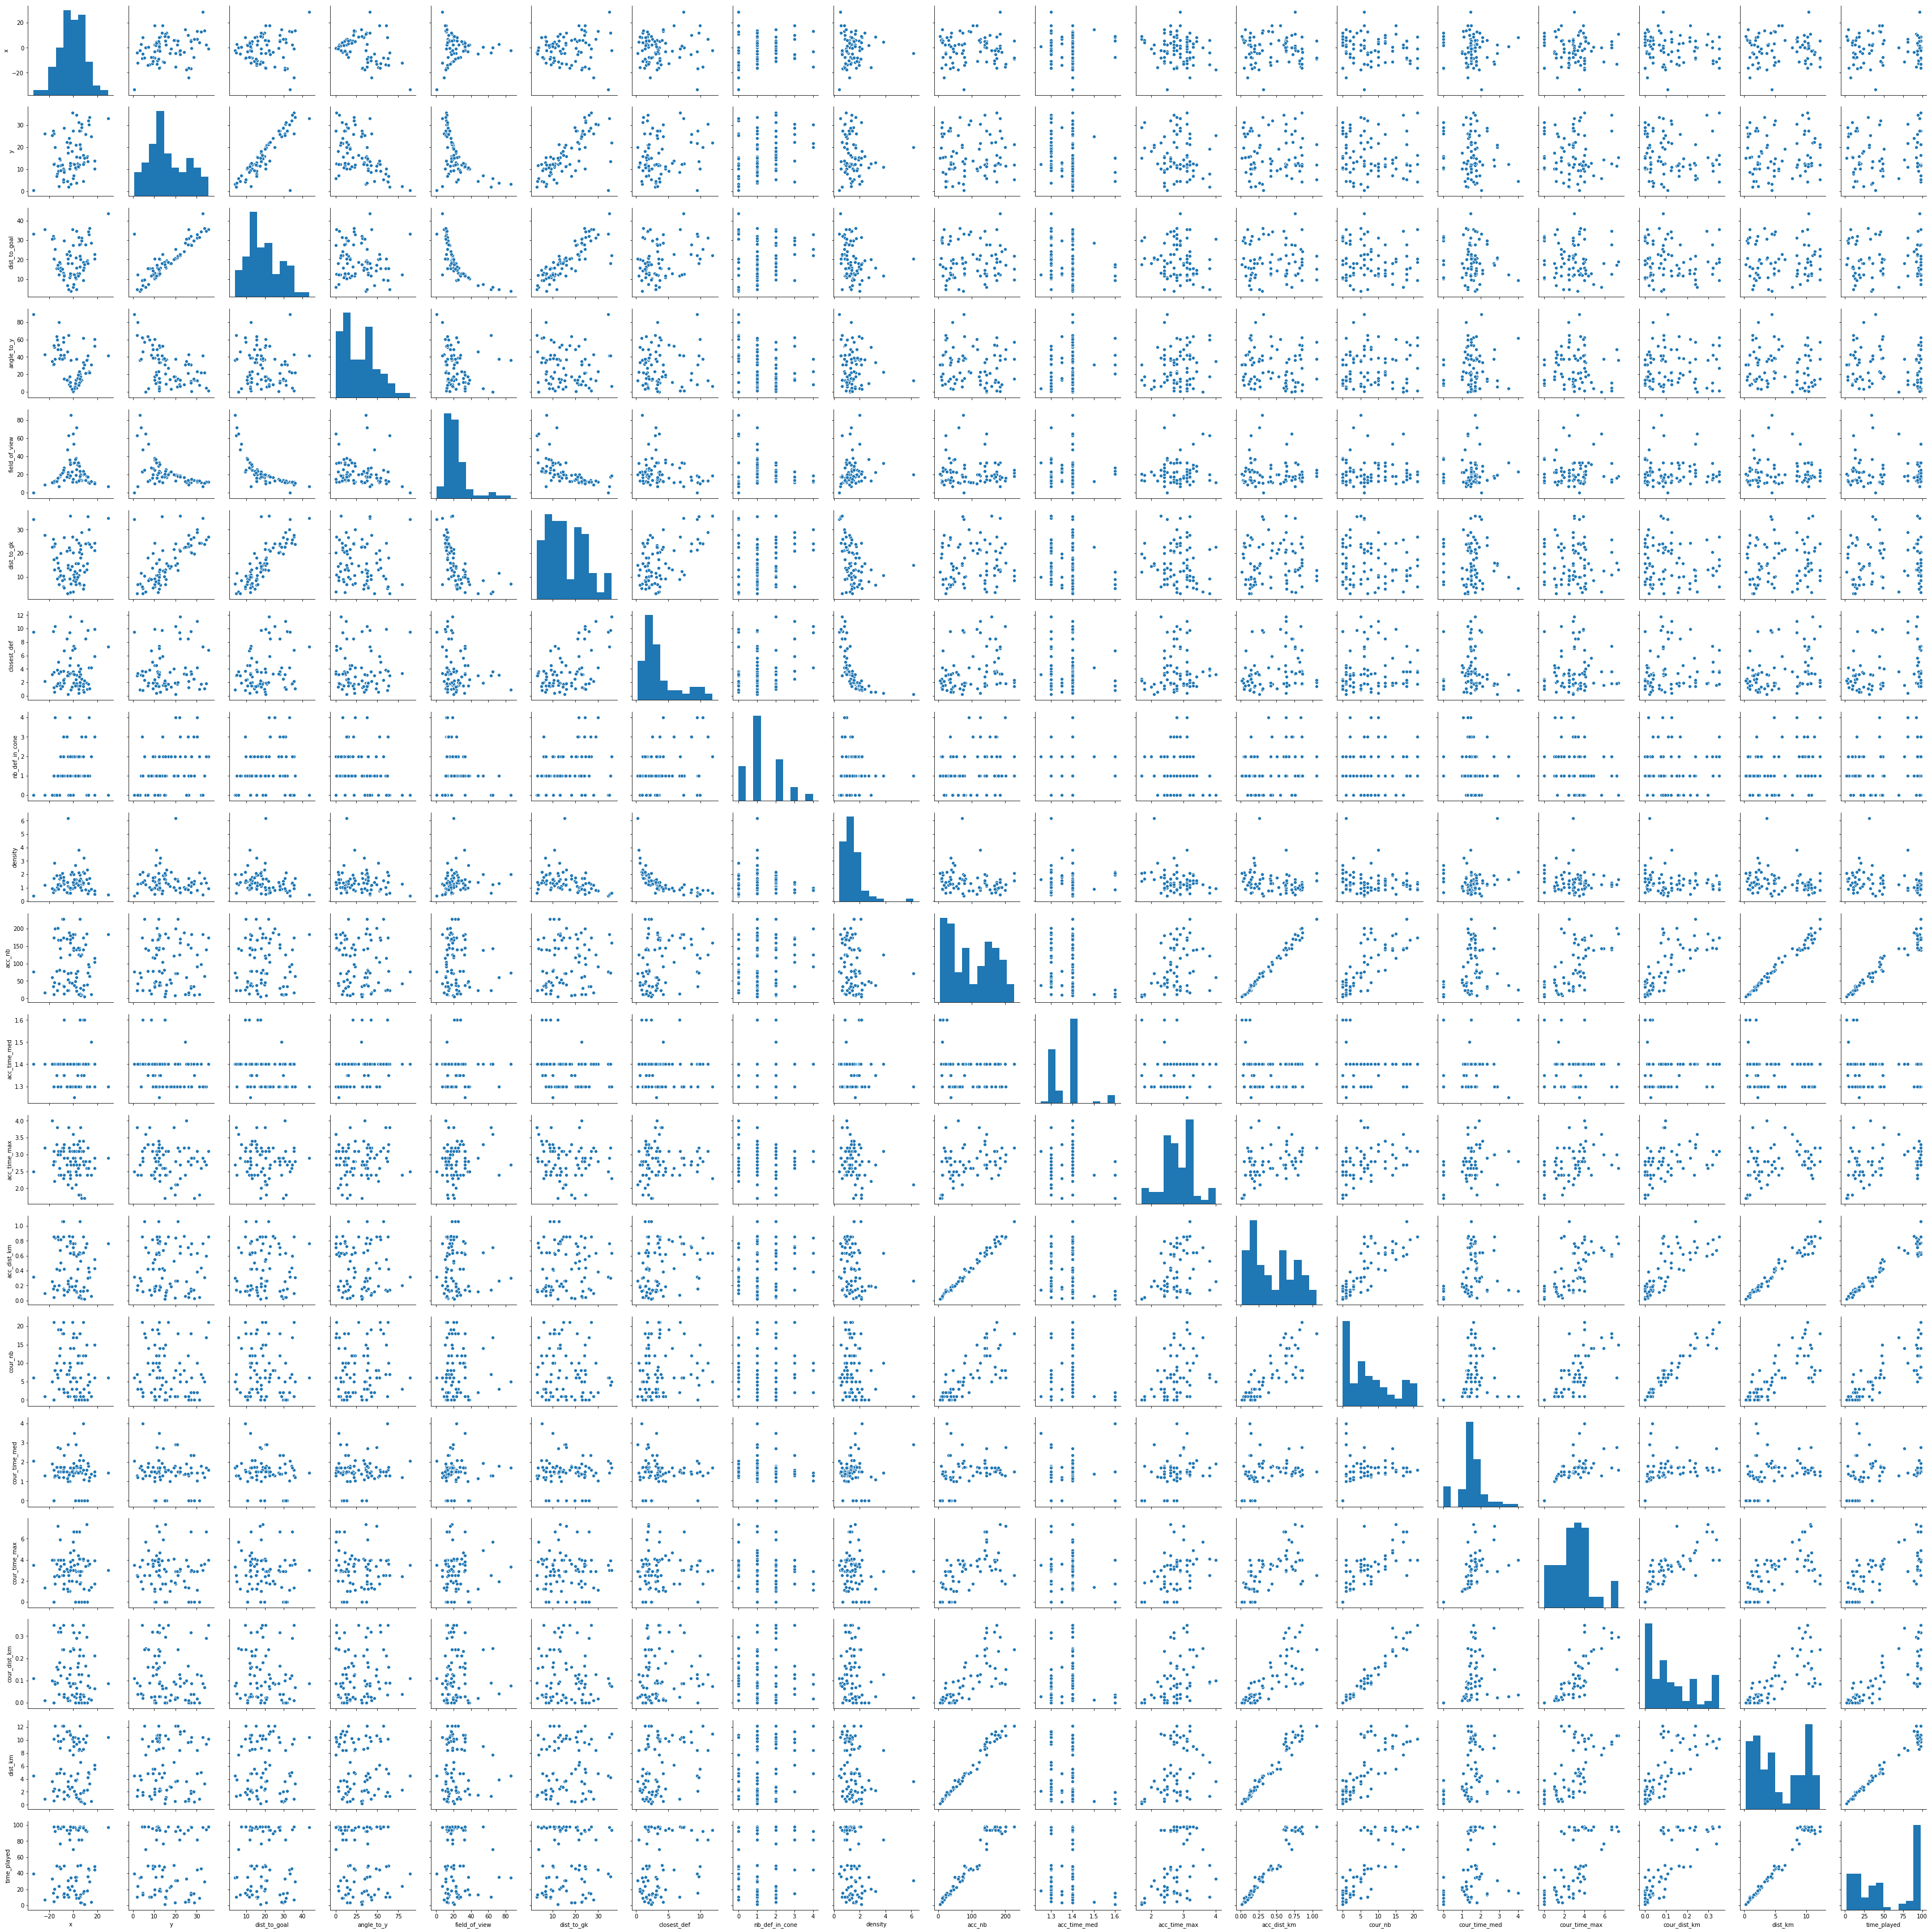

In [7]:
shots.loc[:, features].pipe(sns.pairplot)

Coefficients d'un GLM :

In [20]:
X = shots.loc[:, features].to_numpy(dtype=np.float16)
y = shots.loc[:, "goal"].to_numpy(dtype=np.float16)

In [22]:
clf = LogisticRegression().fit(X, y)

In [32]:
predictions=clf.predict(X[:, :])
predictions

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float16)

In [51]:
from scipy import stats

params = np.append(clf.intercept_,clf.coef_)
newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
# H0 le coef n'a pas d'effet
myDF3["Significance"]=myDF3["Probabilites"]<0.005
myDF3.index = ["Intercept"] + features
print(myDF3.loc[:,['Coefficients', 'Significance']])

                Coefficients  Significance
Intercept             0.1296         False
x                    -0.0032         False
y                    -0.1896          True
dist_to_goal          0.0506         False
angle_to_y           -0.0223          True
field_of_view         0.0259          True
dist_to_gk            0.0064         False
closest_def          -0.0189         False
nb_def_in_cone       -0.8381          True
density              -0.9068          True
acc_nb               -0.0452          True
acc_time_med         -0.1116         False
acc_time_max          0.7029          True
acc_dist_km          -0.0294         False
cour_nb              -0.1563          True
cour_time_med        -0.0244         False
cour_time_max         0.2038         False
cour_dist_km         -0.0223         False
dist_km               0.4757          True
time_played           0.0445          True


In [11]:
clf.predict_proba(X[:3, :])

array([[0.96983489, 0.03016511],
       [0.97935443, 0.02064557],
       [0.21804584, 0.78195416]])

In [12]:
clf.score(X, y)

0.8734177215189873

In [13]:
clf.coef_

array([[-0.0031597 , -0.18962823,  0.05056577, -0.02234796,  0.02587476,
         0.00644219, -0.01885016, -0.83807424, -0.90679962, -0.04521755,
        -0.11162294,  0.70294137, -0.02943766, -0.1562961 , -0.02436026,
         0.20375192, -0.02232045,  0.47574616,  0.04452489]])

In [14]:
shots.loc[:, features]

x          y  dist_to_goal  angle_to_y  field_of_view  dist_to_gk  \
0   11.72  15.726742     19.613485   36.694491      17.226091   15.792308   
1  -15.75  12.582551     20.158946   51.378918      13.190311   12.937484   
2   -2.30   3.125678      3.880704   36.347135      85.839696    7.111188   
3   17.91  13.816703     22.620110   52.351542      11.473864   21.327616   
4   13.10  30.253889     32.968285   23.412717      11.656225   30.025817   
5    2.46  15.484366     15.678558    9.027133      25.997207    9.005870   
6  -16.62  27.259375     31.926446   31.370599      11.219983   26.026888   
7   11.22  15.204973     18.896550   36.424228      17.944295   13.095698   
8    6.90  30.295346     31.071176   12.830689      13.112524   29.011601   
9  -11.07  14.212787     18.015222   37.914172      18.487975   12.524013   
10   4.55  10.849746     11.765181   22.751456      32.425336   10.555743   
11  -3.26  21.787986     22.030523    8.509681      18.671932   21.351274   
12 -13.43   7.760233     15.510838   59.979467      14.037970    9.192938   
13  -4.11   1.948257      4.548385   64.637713      62.917961    2.988143   
14 -15.46  19.954633     25.242800   37.767001      13.178769   24.210122   
15   0.01   5.762222      5.762231    0.099433      64.844997    3.594844   
16  -3.18  10.191033     10.675652   17.329960      36.565306    9.083667   
17  -4.34  17.392941     17.926238   14.010708      22.461469   13.755410   
18 -12.10   2.228894     12.303575   79.562771       6.743534    6.834654   
19  -4.67  19.895093     20.435842   13.209958      19.812677   15.085042   
20   2.18  20.944557     21.057703    5.942196      19.622098   15.644261   
21   6.99  28.794151     29.630444   13.645035      13.700895   19.688682   
22   6.12  19.727604     20.655090   17.235208      19.262009   18.086155   
23  12.71  31.926102     34.363063   21.707841      11.320039   24.323250   
24 -11.54  14.773050     18.746056   37.995251      17.740465   10.255735   
25 -16.32  26.141449     30.817491   31.976365      11.550437   22.972029   
26  -8.20  10.184938     13.075663   38.837904      25.319988    5.905057   
27   2.37  10.066798     10.342017   13.247755      38.223873    6.779971   
28   5.88  27.287969     27.914291   12.160141      14.618834   23.299384   
29  -7.68  28.602069     29.615211   15.030085      13.626605   26.642977   
..    ...        ...           ...         ...            ...         ...   
49   5.66  15.219385     16.237774   20.399872      23.995922    6.802426   
50  -7.76   8.539336     11.538538   42.262544      27.565491    8.993887   
51   5.95  19.221795     20.121628   17.199621      19.768966   21.718085   
52   1.24  12.198125     12.260989    5.804461      33.106652   12.441945   
53 -12.94  11.342545     17.207467   48.763846      16.367150   15.996190   
54  13.69  33.572597     36.256522   22.184310      10.695684   23.965496   
55   5.66  21.108483     21.854145   15.010127      18.410293   12.761994   
56   8.12  12.219237     14.671201   33.605070      23.899490    4.777164   
57  -0.27  27.431197     27.432526    0.563933      15.198147   20.221939   
58  -9.20  11.926250     15.062385   37.646868      22.241548    8.566353   
59   4.28  31.131897     31.424726    7.827928      13.167003   24.372470   
60  -8.20   5.253333      9.738455   57.354328      25.275260   10.413899   
61  -2.35  11.773840     12.006074   11.287620      33.391028    3.390634   
62  28.91  32.940396     43.827592   41.271670       7.204588   34.821834   
63  -3.60  23.973529     24.242321    8.540046      16.991495   22.393778   
64   5.08  11.929036     12.965658   23.066812      29.440579    7.276545   
65   0.86  12.215130     12.245366    4.027235      33.216658    9.849193   
66  -1.02  18.018949     18.047795    3.239889      22.894782   14.422167   
67 -17.58  25.171189     30.702527   34.931124      11.215232   22.621443   
68   1.79  10.616667     10.766509    9.570224      37.162922    8.037537   
69  

In [15]:
params = dict()
for col_name, value in list(zip(list(shots.loc[:, features]), clf.coef_.tolist()[0])):
    params[col_name] = value
    
params

{'x': -0.003159701863127672,
 'y': -0.18962823002962345,
 'dist_to_goal': 0.05056577152258052,
 'angle_to_y': -0.022347959342056477,
 'field_of_view': 0.0258747581674514,
 'dist_to_gk': 0.006442193273733735,
 'closest_def': -0.018850161637389035,
 'nb_def_in_cone': -0.8380742433259987,
 'density': -0.9067996237271316,
 'acc_nb': -0.045217551913560305,
 'acc_time_med': -0.11162293723807054,
 'acc_time_max': 0.7029413729396712,
 'acc_dist_km': -0.029437659262174787,
 'cour_nb': -0.15629609543949777,
 'cour_time_med': -0.024360261959834574,
 'cour_time_max': 0.20375191599444434,
 'cour_dist_km': -0.02232044967446642,
 'dist_km': 0.4757461553617034,
 'time_played': 0.04452488740652191}

In [19]:
clf = SGDClassifier(loss="log", penalty="elasticnet")
clf.fit(X, y)

NameError: name 'X' is not defined

<bound method ClassifierMixin.score of SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)>